# Validation of a Python Solar Wind Speed Calculator
This notebook validates a Python implementation of the Doppler Dimming Technique for calculating solar wind speed maps in the solar corona.

The results from the Python code are compared directly against solar wind speed maps produced by the IDL version of the algorithm, which serves as the validation benchmark. 

The ultraviolet (UV) and electron density ($N_e$) data are derived from the [Metis](https://metis.oato.inaf.it/index.html) coronagraph onboard the [Solar Orbiter](https://www.esa.int/Science_Exploration/Space_Science/Solar_Orbiter) spacecraft.

- Author: Dario Vetrano
- Date: August 2025
- Contact: dario.vetrano@studenti.polito.it

## Importing libraries and environment setup

In [104]:
# =============================================================================
#  1. CORE LIBRARIES 
# =============================================================================
import os
import sys
import platform
import time
import warnings
from pathlib import Path
from os.path import basename

# =============================================================================
#  2. SCIENTIFIC COMPUTING LIBRARIES
# =============================================================================
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 16

import matplotlib.ticker as ticker
from matplotlib import cm
from scipy.optimize import brentq, curve_fit, least_squares
from scipy.interpolate import interp1d
from scipy import ndimage

# =============================================================================
#  3. ASTRONOMY & ASTROPHYSICS LIBRARIES
# =============================================================================
import astropy.units as u
from astropy.io import fits
from astropy.wcs import FITSFixedWarning, WCS
from astropy.io.fits.verify import VerifyWarning
import sunpy.map
from sunpy.sun import constants

# --- CHIANTI Atomic Database Setup ---
# ChiantiPy requires the $XUVTOP environment variable to point to the database location.
# This section sets the path programmatically.

# First, ensure the HOME variable is set, which is sometimes needed for Windows users
if 'HOME' not in os.environ and platform.system() == 'Windows':
    os.environ['HOME'] = os.path.expanduser('~')

# !!! IMPORTANT !!!
# You must replace the path below with the location of the CHIANTI database on your computer.
# xuvtop_path = r'C:\PATH\TO\YOUR\CHIANTI_11.0.2_database'
xuvtop_path = r'C:\Users\Lenovo1\Desktop\CORONA HYDRODYNAMIC STABILITY\Doppler Dimming Technique\codice\CHIANTI_DB\CHIANTI_11.0.2_database' 
os.environ['XUVTOP'] = xuvtop_path

import ChiantiPy.core as ch

# =============================================================================
#  4. JUPYTER NOTEBOOK & UTILITY LIBRARIES
# =============================================================================
from IPython.display import clear_output

# =============================================================================
#  5. LOCAL MODULES & CUSTOM FUNCTIONS
# =============================================================================
from aux_lib_lyman_alpha import integrate_intensity_los, get_Gibson_temperature, precompute_los_arrays
from metis_aux_lib import calc_el_dens_and_K, polar_to_cart, align_polar_maps, fit_negative_power_series, cut_metis_fov, cart_to_polar

# =============================================================================
#  6. ENVIRONMENT CONFIGURATION
# =============================================================================
# Suppress a common, often benign, warning from Astropy when reading FITS headers
warnings.filterwarnings('ignore', category=FITSFixedWarning)
warnings.simplefilter('ignore', category=VerifyWarning)

# =============================================================================
#  7. JUPYTER MAGIC COMMANDS
# =============================================================================
%reload_ext autoreload
%autoreload 2

## Load the Metis UV data

In [45]:
path_uv = Path(r"./Giordano/solo_L2_metis-uv-20210114T004530-cmb_0.85_1.fts")

fits_uv = fits.open(path_uv)[0] 

fits_uv.header['RSUN_OBS'] = fits_uv.header['RSUN_ARC']
date_UV = fits_uv.header.get("DATE_OBS") 

map_uv = sunpy.map.Map(fits_uv.data, fits_uv.header)

cut_metis_fov(fits_uv)

METIS_UV_CMAP = plt.colormaps["RdYlBu_r"].copy()
METIS_UV_CMAP.set_bad(color='tab:gray')

## Coordinate transformation and visual representation of the UV maps

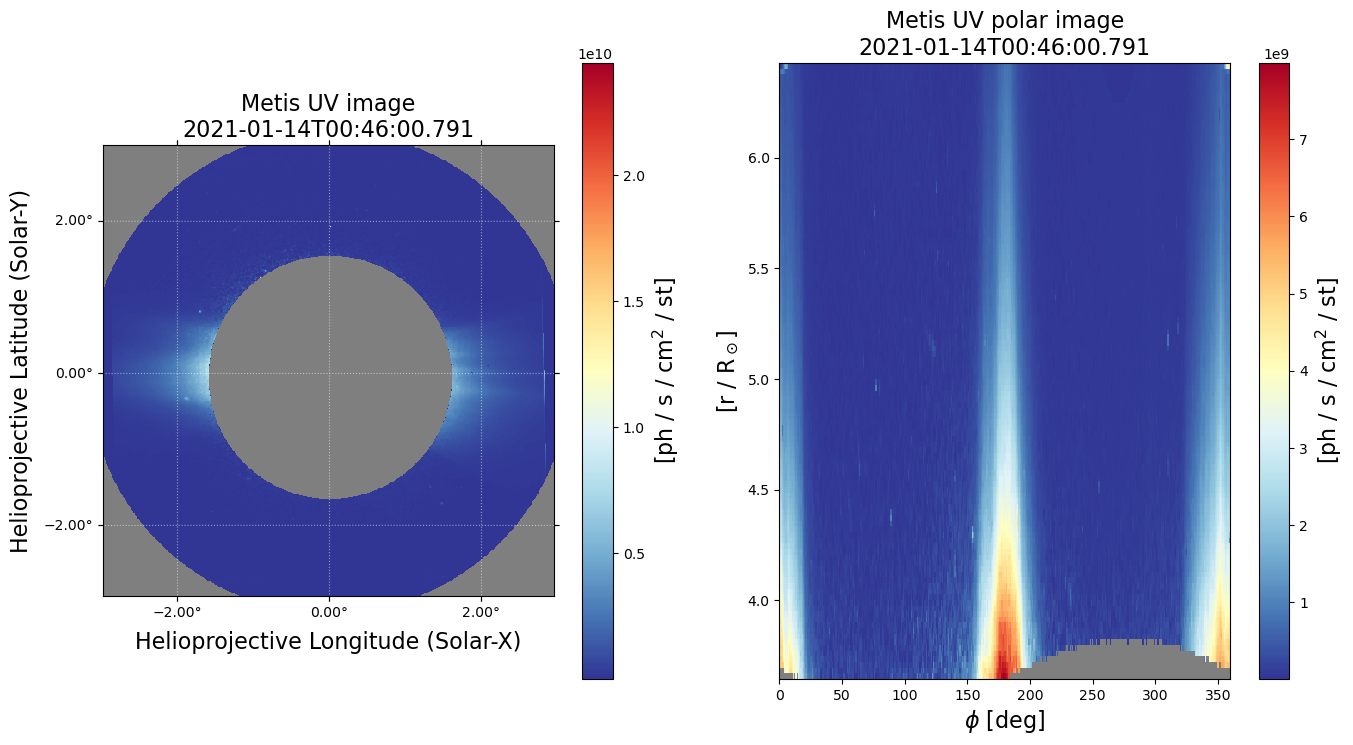

In [47]:
polar_uv, r_matrix_uv_pix, r_arr_uv, rsun_pix_uv, phi_arr_uv = cart_to_polar(fits_uv, dr = 1, dphi = 1, rot_angle=None, cval=np.nan, cut_out_fov = 50, cut_in_fov = 0)

r_matrix_uv = r_matrix_uv_pix / rsun_pix_uv
r_arr_uv = r_arr_uv / rsun_pix_uv

wcs_uv = WCS(fits_uv.header)

# PLOT
fig = plt.figure(figsize=(16, 8))

ax0 = fig.add_subplot(1, 2, 1, projection=wcs_uv)

img_uv = ax0.imshow(fits_uv.data, origin='lower', cmap=METIS_UV_CMAP, interpolation='none')
cbar_uv = plt.colorbar(img_uv, ax=ax0, label= '[ph / s / cm$^2$ / st]')

lon, lat = ax0.coords
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')
ax0.coords.grid(True, color = 'white', ls = 'dotted', alpha = 0.5)
ax0.set_xlabel('Helioprojective Longitude (Solar-X)')
ax0.set_ylabel('Helioprojective Latitude (Solar-Y)')
ax0.set_title('Metis UV image\n' + date_UV)


ax1 = fig.add_subplot(1, 2, 2)  
img_uv_pol = ax1.imshow(polar_uv, origin='lower', cmap=METIS_UV_CMAP, interpolation='none',  extent=[0, polar_uv.shape[1], r_arr_uv[0], r_arr_uv[-1]], aspect = 'auto')
ax1.set_ylabel("[r / R$_\\odot$]")
ax1.set_xlabel("$\phi$ [deg]")
cbar_uv_pol = plt.colorbar(img_uv_pol, ax=ax1, label='[ph / s / cm$^2$ / st]')
ax1.set_title('Metis UV polar image\n' + date_UV);

## Load the Electron Density ($N_e$) maps

In [48]:
path_ne = Path("./Giordano/solo_L2_metis-vl-pb_20210114T003001_V01_1_0.71_ne.fts")

fits_ne = fits.open(path_ne)[0]

date_ne = fits_ne.header.get("DATE_OBS") 

cut_metis_fov(fits_ne)

METIS_NE_CMAP = plt.colormaps["plasma"].copy()
METIS_NE_CMAP.set_bad(color='tab:gray') 

## Coordinate transformation and visual representation of the $N_e$ maps

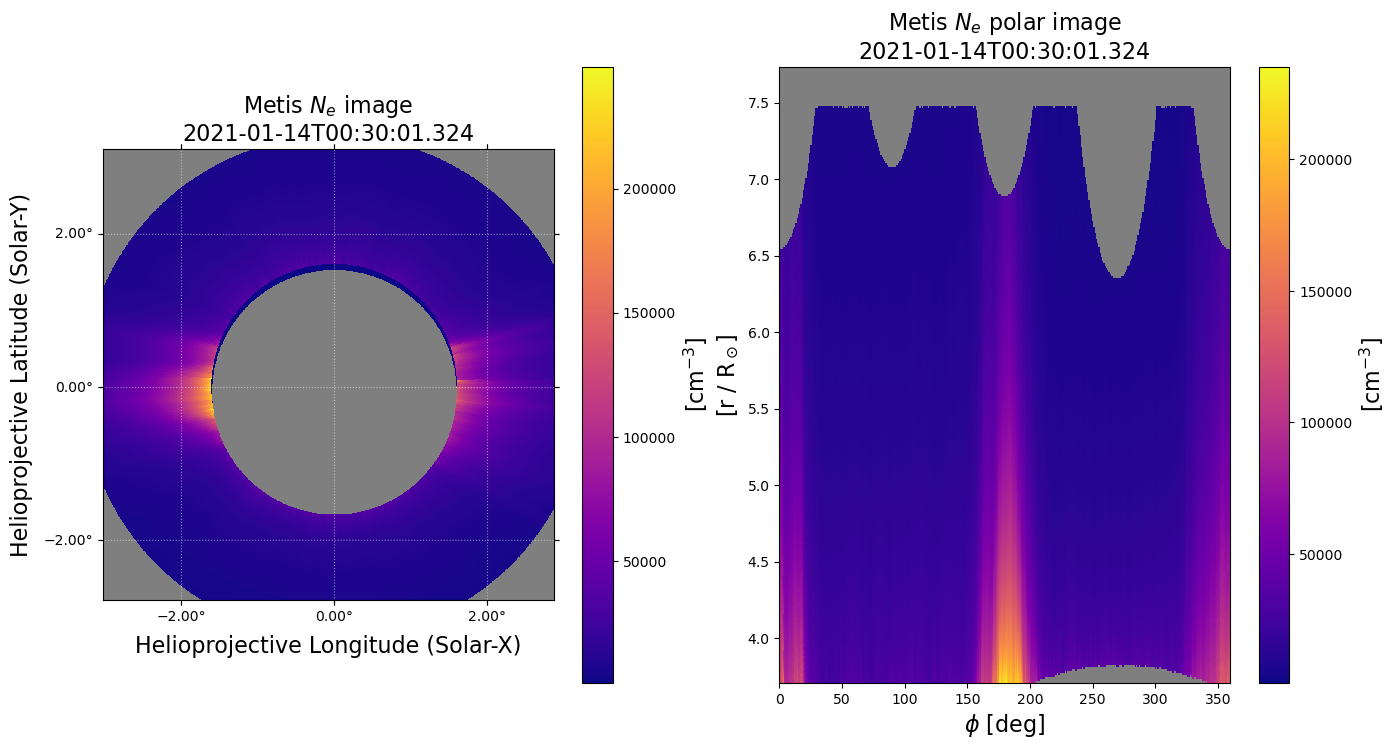

In [51]:
polar_ne, r_matrix_ne_pix, r_arr_ne, rsun_pix_ne, phi_arr_ne = cart_to_polar(fits_ne, dr = 1, dphi = 1, cval=np.nan, cut_out_fov = 0, cut_in_fov = 5)

r_matrix_ne = r_matrix_ne_pix / rsun_pix_ne
r_arr_ne = r_arr_ne / rsun_pix_ne

wcs_ne = WCS(fits_ne.header)

# PLOT
fig = plt.figure(figsize=(16, 8))

ax0 = fig.add_subplot(1, 2, 1, projection=wcs_ne)

img_ne = ax0.imshow(fits_ne.data, origin='lower', cmap=METIS_NE_CMAP, interpolation='none')
cbar_ne = plt.colorbar(img_ne, ax=ax0, label='[cm$^{-3}$]')

lon, lat = ax0.coords
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')
ax0.coords.grid(True, color = 'white', ls = 'dotted', alpha = 0.5)
ax0.set_xlabel('Helioprojective Longitude (Solar-X)')
ax0.set_ylabel('Helioprojective Latitude (Solar-Y)')
ax0.set_title('Metis $N_e$ image\n' + date_ne)

ax1 = fig.add_subplot(1, 2, 2)  
img_ne_pol = ax1.imshow(polar_ne, origin='lower', cmap=METIS_NE_CMAP, interpolation='none',  extent=[0, polar_ne.shape[1], r_arr_ne[0], r_arr_ne[-1]], aspect = 'auto')
ax1.set_ylabel("[r / R$_\\odot$]")
ax1.set_xlabel("$\phi$ [deg]")
# ax1.yaxis.set_major_locator(ticker.MultipleLocator(base=0.1))
cbar_uv_pol = plt.colorbar(img_ne_pol, ax=ax1, label='[cm$^{-3}$]')
ax1.set_title('Metis $N_e$ polar image\n' + date_ne);

## Pre-processing of the Polar Maps (UV and $N_e$)

To allow for a direct, pixel-by-pixel comparison, the UV and $N_e$ polar maps must have the same shape to ensure they are perfectly overlapping.
By convention, we resample the UV map to match the $N_e$ map. A final mask is the applied to keep only the pixels where both maps have non-NaN values.

Visual representation of the various arrays (and matrices) defined inside the function align_polar_maps:

![geometry_overlap_visual](geometry_overlap_visual.png)




--- Aligning Polar Maps ---
Original A shape: (109, 360), Original B shape: (315, 360)
Resampled A shape: (212, 360), Resampled B shape: (212, 360)
New common grid created with 212 radial steps from 3.71 R☉ to 6.43 R☉.
--- Alignment Complete ---


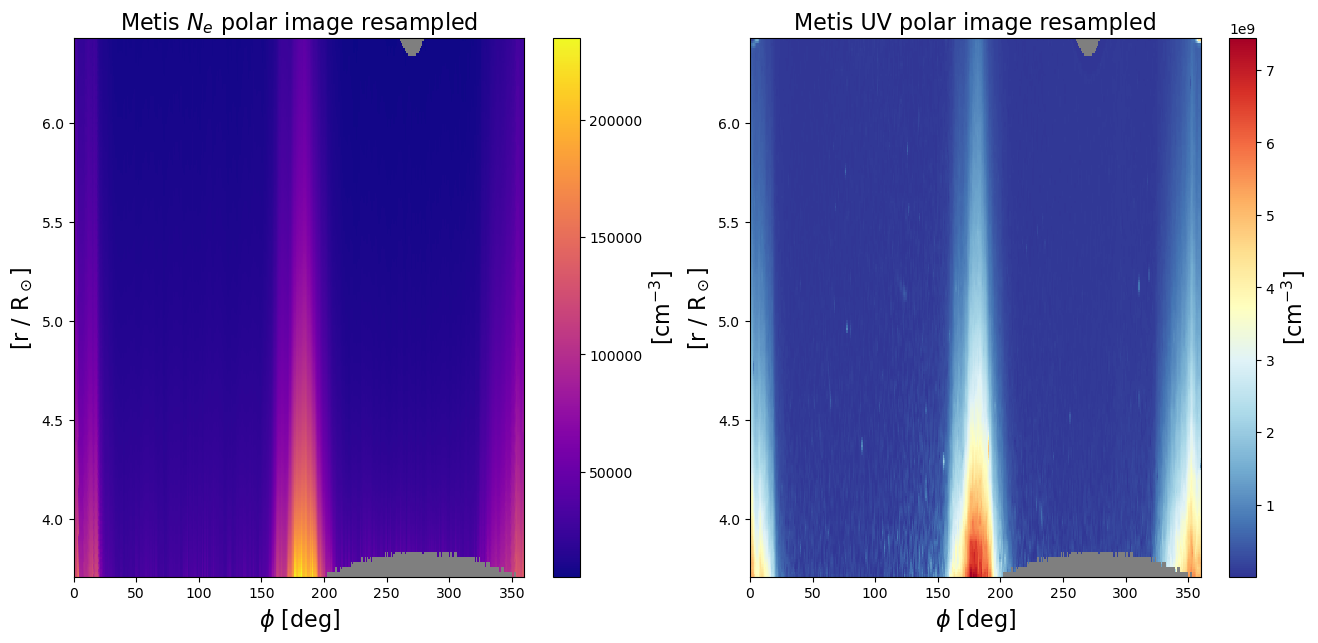

In [53]:
polar_uv_resam, polar_ne_resam, r_matrix, r_common = align_polar_maps(polar_uv, r_matrix_uv, r_arr_uv, polar_ne, r_matrix_ne, r_arr_ne)

fig = plt.figure(figsize=(16, 7))

ax1 = fig.add_subplot(1, 2, 1)  
img_ne_pol = ax1.imshow(polar_ne_resam, origin='lower', cmap=METIS_NE_CMAP, interpolation='none', extent=[0, polar_ne_resam.shape[1], r_common[0], r_common[-1] ], aspect = 'auto')
ax1.set_ylabel("[r / R$_\\odot$]")
ax1.set_xlabel("$\phi$ [deg]")
cbar_uv_pol = plt.colorbar(img_ne_pol, ax=ax1, label='[cm$^{-3}$]')
ax1.set_title('Metis $N_e$ polar image resampled');

ax2 = fig.add_subplot(1, 2, 2)  
img_uv_pol = ax2.imshow(polar_uv_resam, origin='lower', cmap=METIS_UV_CMAP, interpolation='none', extent=[0, polar_uv_resam.shape[1], r_common[0] , r_common[-1] ], aspect = 'auto')
ax2.set_ylabel("[r / R$_\\odot$]")
ax2.set_xlabel("$\phi$ [deg]")
cbar_ne_pol = plt.colorbar(img_uv_pol, ax=ax2, label='[cm$^{-3}$]')
ax2.set_title('Metis UV polar image resampled');

## Calculating the Solar Wind Velocity Map
The core of the analysis is to determine the Solar Wind speed for each pixel in the pre-processed polar maps (UV and $N_e$): this is achieved through the definition of a resonant scattering model, and iteratively solving for the velocity that reproduces the observed UV intensity.

The algorithm iterates through every valid pixel, defined by its radius $r \in [\text{IN\_FOV}, \text{OUT\_FOV}]$ and polar angle $\phi \in [\phi_{\text{ROI,min}}, \phi_{\text{ROI,max}}]$.

In [54]:
"""
- Since now polar_ne and polar_uv (more precisely, their resampled versions) have the same shape, we could use both: by convention, we will refer to polar_ne
- Computing the full range of φ from 0° to 360° (i.e., 360 radials) takes ~ 1 h 15 min (calculating 10 radials requires ~ 2 min 5 s)
""" 
"""
- Adjust angle_ROI to select the desired radial(s). In the Cartesian image, the angle
  is defined as zero when pointing east and increases positively in the counterclockwise (CCW) direction.
"""

angle_ROI = np.r_[340:341] # [deg] 

"""
"""

velocity_map_kms = np.zeros_like(polar_ne_resam)

r_matrix_ROI = r_matrix[:, angle_ROI]  # [Rsun]

total_pixels = np.sum(~np.isnan(r_matrix_ROI))

current_pixel = 0

for i, angle in enumerate(angle_ROI):
    r_arr = r_matrix[:, angle][~np.isnan(polar_ne_resam[:, angle])]
    radial_ne = polar_ne_resam[~np.isnan(polar_ne_resam[:, angle]), angle]

    model, coeffs = fit_negative_power_series(r_arr, radial_ne, degree=3)
    radial_interp_ne = model

    # radial_interp_ne = interp1d(r_arr, radial_ne, kind='linear', fill_value="extrapolate")
    r_max = r_arr[-1] # To set the integration bounds along the LOS
    
    clear_output(wait=True)
    print(f"Processing angle: {i+1} / {len(angle_ROI)}")
    print(f"{current_pixel} / {total_pixels} pixels processed ({current_pixel / total_pixels * 100:.2f} % completed)")
    
    for j, r_pos in enumerate(r_arr):
        
        current_pixel += 1

        I_obs = polar_uv_resam[j, angle]

        if np.isnan(I_obs):
            velocity_map_kms[j, angle] = np.nan
            # print("I_obs is NaN")
            continue
            
        r_3d, n_e_arr, Te_arr, beta_arr, x_cm, theta_mat = precompute_los_arrays(r_pos, radial_interp_ne, r_max)
    
        I_static = integrate_intensity_los(0, r_3d, n_e_arr, Te_arr, beta_arr, theta_mat, x_cm)

        # print(f" --- I_static: {I_static:.2e}, I_observed: {I_obs:.2e} ---")
           
        def objective_function(vw_kms):
            return integrate_intensity_los(vw_kms, r_3d, n_e_arr, Te_arr, beta_arr, theta_mat, x_cm) - I_obs

        if I_static <= I_obs:  

            if np.isclose(I_static, I_obs, rtol=5e-2):
                velocity_map_kms[j, angle] = 0
                # print("ΔI < 5% => Vw set to 0 km/s")
                continue
            else:
                velocity_map_kms[j, angle] = np.nan
                # print("I_obs < I_static => Vw set to NaN")
                continue

        else:
            try:
                found_velocity = brentq(objective_function, a=0.1, b = 500, xtol=1, rtol=0.01)
                # print(f"Found_velocity: {found_velocity:.2f} km/s")    
                velocity_map_kms[j, angle] = found_velocity
            except ValueError:
                velocity_map_kms[j, angle] = np.nan
                print("Value Error in brentq")
                
clear_output(wait = True)
print(f"Velocity map computation completed for {current_pixel} pixel.")

Velocity map computation completed for 210 pixel.


### If necessary, upload a precomputed map stored as an .npy file. In this case, it will upload the full 360 deg map:

In [55]:
# np.save("vw_map_test_XX.npy", velocity_map_kms)

velocity_map_kms = np.load('vw_map_test_full_360.npy')

## Load the benchmark velocity map, apply coordinate transformation, and visualize


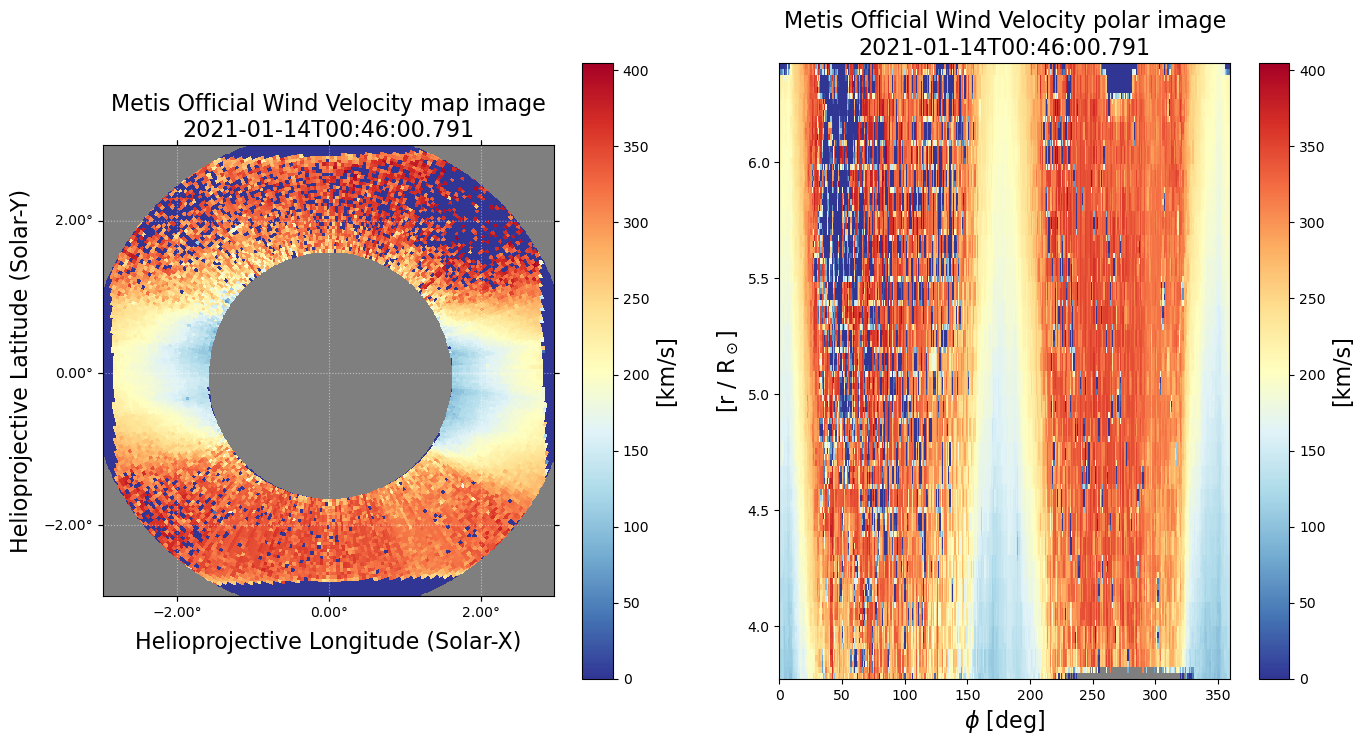

In [56]:
path_Vw = Path(r"./Giordano/ddt_ws_20210114T004530_Gi_10_100_1.fts")

fits_Vw = fits.open(path_Vw)[0]

fits_Vw.header = fits_uv.header
fits_Vw.data = fits_Vw.data / 1e5

date_off_Vw = fits_Vw.header.get("DATE_OBS") 

cut_metis_fov(fits_Vw)

polar_Vw, r_matrix_Vw, r_arr_Vw, rsun_pix_Vw, phi_arr_Vw = cart_to_polar(fits_Vw, cval=np.nan, cut_out_fov = 50, cut_in_fov = 5)

r_arr_Vw /= rsun_pix_Vw # [pix] → [R☉]

wcs_Vw = WCS(fits_Vw.header)

fig = plt.figure(figsize=(16, 8))

# WCS image
ax0 = fig.add_subplot(1, 2, 1, projection=wcs_Vw)

img_Vw = ax0.imshow(fits_Vw.data, origin='lower', cmap=METIS_UV_CMAP, interpolation='none')
cbar_Vw = plt.colorbar(img_Vw, ax=ax0, label='[km/s]')

lon, lat = ax0.coords
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')
ax0.coords.grid(True, color = 'white', ls = 'dotted', alpha = 0.5)
ax0.set_xlabel('Helioprojective Longitude (Solar-X)')
ax0.set_ylabel('Helioprojective Latitude (Solar-Y)')
ax0.set_title('Metis Official Wind Velocity map image\n' + date_off_Vw)


ax1 = fig.add_subplot(1, 2, 2)  
img_Vw_pol = ax1.imshow(polar_Vw, origin='lower', cmap=METIS_UV_CMAP, interpolation='none',  extent=[0, polar_ne.shape[1], r_arr_Vw[0], r_arr_Vw[-1]], aspect = 'auto')
ax1.set_ylabel("[r / R$_\\odot$]")
ax1.set_xlabel("$\phi$ [deg]");
cbar_Vw_pol = plt.colorbar(img_Vw_pol, ax=ax1, label='[km/s]')
ax1.set_title('Metis Official Wind Velocity polar image\n' + date_off_Vw);

## Aligning my Solar Wind speed map and Official Solar Wind speed map for comparison:

In [75]:
my_cartesian_Vw = polar_to_cart(velocity_map_kms, (1024, 1024), 512, 512, rsun_pix_ne, r_common[0], r_common[-1], 1 / rsun_pix_ne, rot_angle=None, cut_fov=True)

my_Vw_map_resam, official_Vw_map_resam, r_matrix_common_Vw, r_common_Vw = align_polar_maps(velocity_map_kms, r_matrix, r_common, polar_Vw, r_matrix_Vw / rsun_pix_Vw, r_arr_Vw)

--- Aligning Polar Maps ---
Original A shape: (212, 360), Original B shape: (104, 360)
Resampled A shape: (206, 360), Resampled B shape: (206, 360)
New common grid created with 206 radial steps from 3.77 R☉ to 6.43 R☉.
--- Alignment Complete ---


## Comparison:

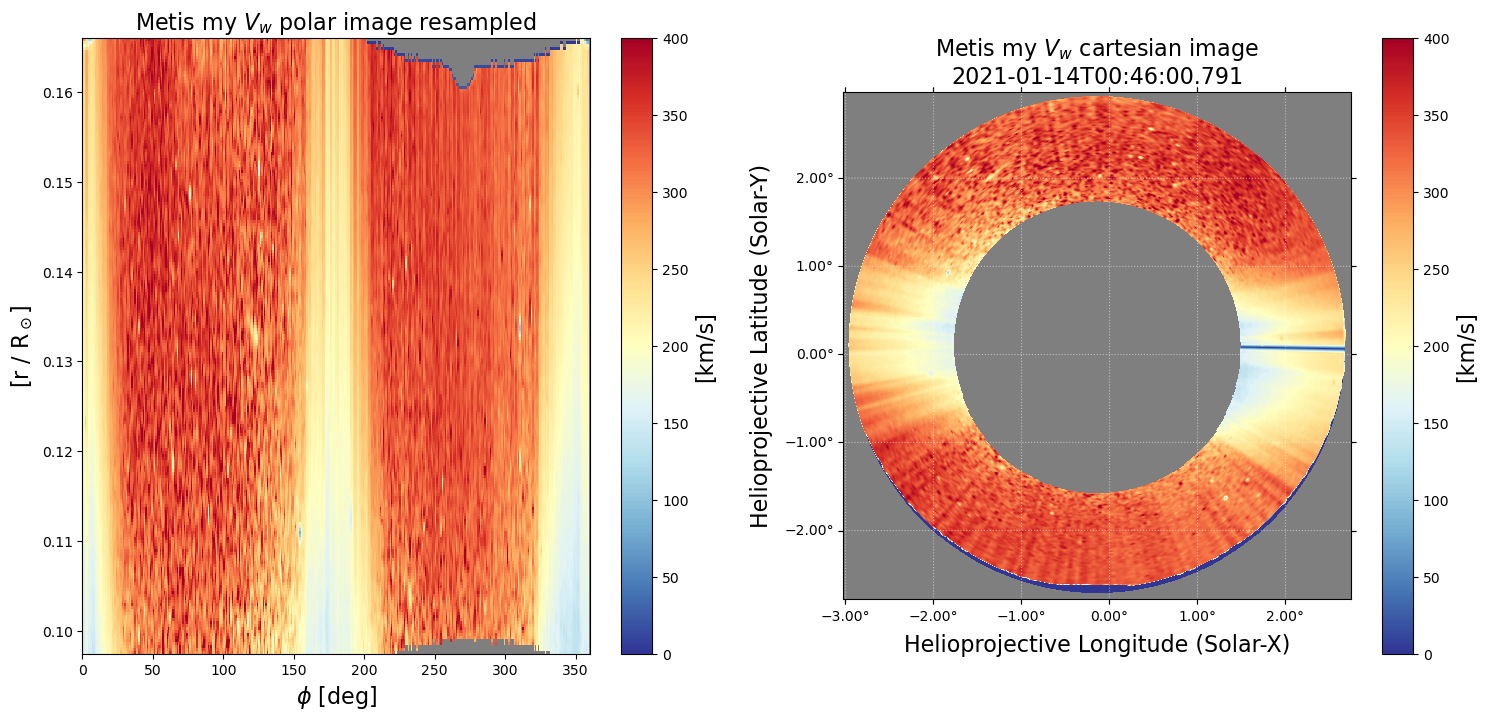

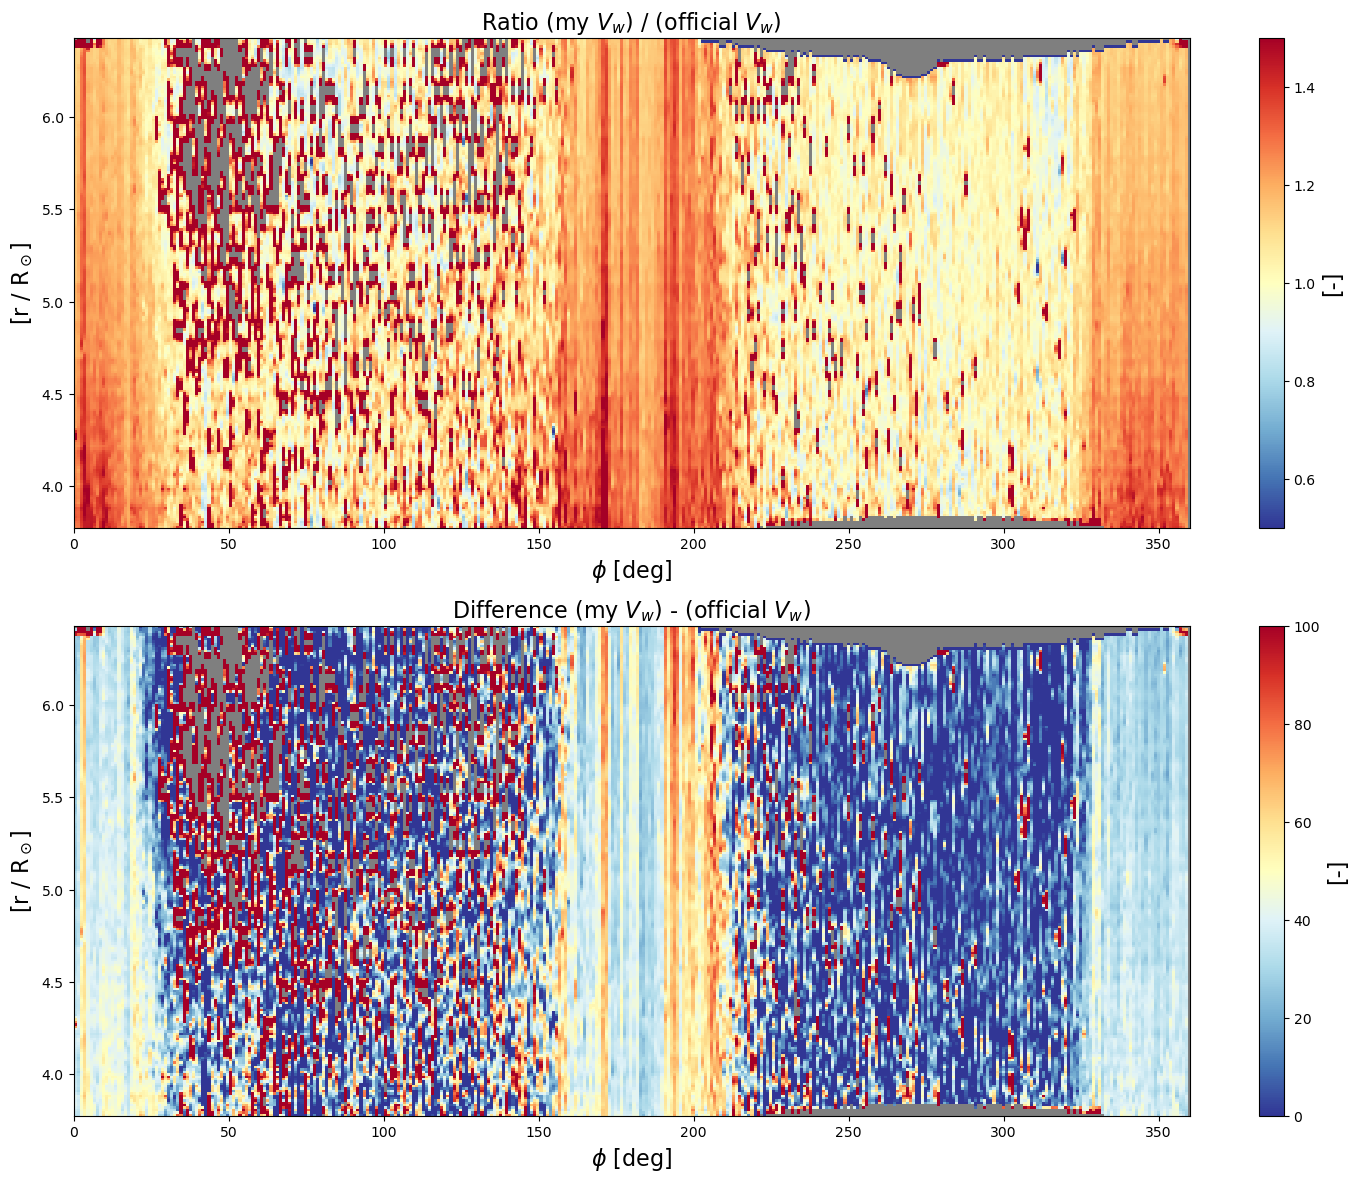

In [94]:
fig0 = plt.figure(figsize=(18, 8))

ax0 = fig0.add_subplot(1, 2, 1)  
img_Vw_pol = ax0.imshow(my_Vw_map_resam, origin='lower', cmap=METIS_UV_CMAP, interpolation='none',  vmin = 0, vmax = 400 , extent=[0, polar_ne.shape[1], r_arr_Vw[0] / rsun_pix_Vw, r_arr_Vw[-1] / rsun_pix_Vw], aspect = 'auto')
ax0.set_ylabel("[r / R$_\\odot$]")
ax0.set_xlabel("$\phi$ [deg]");

my_cbar_Vw= plt.colorbar(img_Vw_pol, ax=ax0, label='[km/s]')
ax0.set_title('Metis my $V_w$ polar image resampled');

ax1 = fig0.add_subplot(1, 2, 2, projection=wcs_ne)

img_Vw = ax1.imshow(my_cartesian_Vw, origin='lower', cmap=METIS_UV_CMAP,  vmin = 0, vmax = 400, interpolation='none')
cbar_Vw = plt.colorbar(img_Vw, ax=ax1, label='[km/s]')

lon, lat = ax1.coords
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')
ax1.coords.grid(True, color = 'white', ls = 'dotted', alpha = 0.5)
ax1.set_xlabel('Helioprojective Longitude (Solar-X)')
ax1.set_ylabel('Helioprojective Latitude (Solar-Y)')
ax1.set_title('Metis my $V_w$ cartesian image\n' + date_off_Vw)

fig1 = plt.figure(figsize=(18, 14))

ax4 = fig1.add_subplot(2, 1, 1)

img_Vw_pol = ax4.imshow(my_Vw_map_resam / official_Vw_map_resam, origin='lower', cmap=METIS_UV_CMAP, interpolation='none', vmin = 0.5, vmax = 1.5, extent=[0, polar_ne.shape[1], r_common_Vw[0] , r_common_Vw[-1] ], aspect = 'auto')
ax4.set_ylabel("[r / R$_\\odot$]")
ax4.set_xlabel("$\phi$ [deg]");

my_cbar_Vw = plt.colorbar(img_Vw_pol, ax=ax4, label='[-]')
ax4.set_title('Ratio (my $V_w$) / (official $V_w$)');


ax5 = fig1.add_subplot(2, 1, 2)

img_Vw_pol = ax5.imshow(my_Vw_map_resam - official_Vw_map_resam, origin='lower', cmap=METIS_UV_CMAP, interpolation='none', vmin = 0, vmax = 100, extent=[0, polar_ne.shape[1], r_common_Vw[0] , r_common_Vw[-1] ], aspect = 'auto')
ax5.set_ylabel("[r / R$_\\odot$]")
ax5.set_xlabel("$\phi$ [deg]");

my_cbar_Vw = plt.colorbar(img_Vw_pol, ax=ax5, label='[-]')
ax5.set_title('Difference (my $V_w$) - (official $V_w$)');


## Conclusions

As can be seen in detail by looking at the direct comparison between some radials in the equatorial regions (i.e., where the radials are smoother and the difference between my and official values is higher):

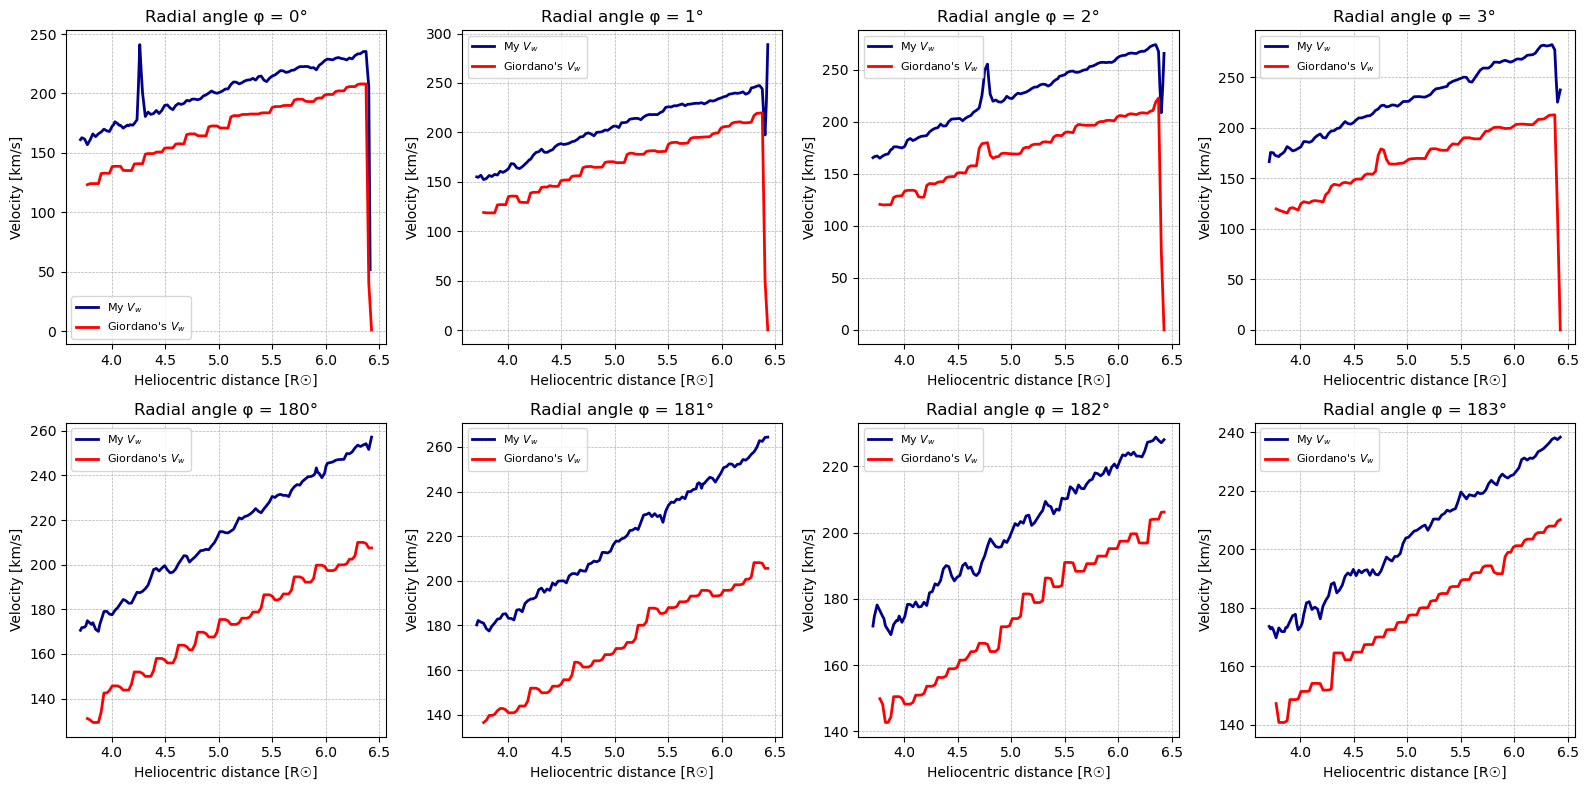

In [100]:
angle_ROI_plot = np.r_[0:4, 180:184]

ncols = 4
nrows = round(np.ceil(len(angle_ROI_plot) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows))
axes = axes.flatten()

for ax, phi_select in zip(axes, angle_ROI_plot):
    r_radial = r_matrix[:, phi_select]
    v_radial = velocity_map_kms[:, phi_select]

    r_radial_G = r_matrix_Vw[:, phi_select] / rsun_pix_Vw
    v_radial_G = polar_Vw[:, phi_select]

    interpolator_v = interp1d(r_radial_G, v_radial_G, kind='linear', fill_value="extrapolate")
    v_radial_G_new = interpolator_v(r_radial)
    
    ax.plot(r_radial, v_radial, color='darkblue', linewidth=2)
    ax.plot(r_radial_G, v_radial_G, color='red', linewidth=2)
    ax.set_title(f"Radial angle φ = {phi_select}°", fontsize=12)
    ax.set_ylabel("Velocity [km/s]", fontsize=10)
    ax.set_xlabel("Heliocentric distance [R☉]", fontsize=10)
    ax.grid(True, which="both", linestyle='--', linewidth=0.5)
    ax.legend(["My $V_w$", "Giordano's $V_w$"], fontsize=8)

# Hide the last empty subplot (if any)
for ax in axes[len(angle_ROI_plot):]:
    ax.set_visible(False)

plt.tight_layout()

plt.savefig('radial_cfr_btw_maps.png')
plt.show()


The results obtained with the Python version (blue lines) are consistently higher than those from the official IDL implementation (either by some multiplicative factor or possibly by a constant offset).

**Possible causes:**

1. Unspotted errors in the constants adopted and/or in the formulae?

2. In *Giordano et al., 2025* ("Solar wind speed maps from the Metis coronagraph observations") between lines 500–510 (pp. 7–8), the authors state:

> *"An initial solar wind speed map was obtained by assuming a constant speed along the LOS for each spatial element in the plane of the sky. In a second iteration over all spatial elements, we then recalculated the intensity of H I Lyα and compared it with the observed values by adopting a speed profile along the LOS. These profiles were defined for each radial direction and were derived from a monotonic fit to the radial speed distribution obtained from the initial image. In this way, the LOS contributions were treated more realistically, under the assumption that the outflow speed increases with heliocentric distance."*
> 
 Could it be that the “official” map used for comparison is actually the refined, second-iteration output? (My results are from the constant radial-speed approach).
